<a href="https://colab.research.google.com/github/Sanjay1245/DEMO/blob/main/Copy_of_Test_U_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob

In [ ]:
image_directory = "/content/drive/MyDrive/Colab Notebooks/data/train_images"
mask_directory = "/content/drive/MyDrive/Colab Notebooks/data/train_masks"

In [ ]:
SIZE = 256
num_images = 250

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/train_images/*.jpg")
print(image_names)

['/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx1914.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx1897.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx1934.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx1899.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx19.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx1926.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx191.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx1919.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx1929.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx1911.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx1905.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx1936.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_images/imgx1909.jpg', '/content/drive/MyDrive/Colab Notebooks/data/train_im

In [ ]:
image_names.sort()

In [ ]:
image_names_subset = image_names[0:num_images]

In [ ]:
images = [cv2.imread(img, 0) for img in image_names_subset]

In [ ]:
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/train_masks/*.jpg")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [ ]:
image_dataset = image_dataset /255.

In [ ]:
mask_dataset = mask_dataset /255.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

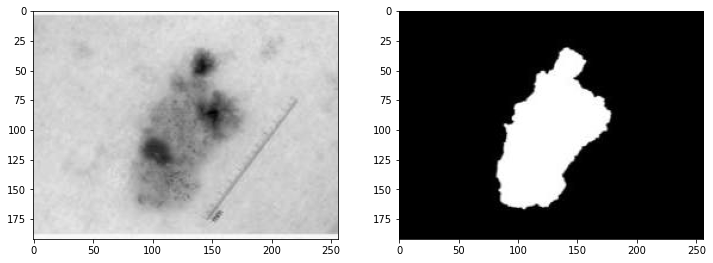

In [ ]:
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 192, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False) 

Epoch 1/50
50/50 [==============================] - 37s 746ms/step - loss: 0.1136 - accuracy: 0.9052 - val_loss: 0.2746 - val_accuracy: 0.8771
Epoch 2/50
50/50 [==============================] - 36s 723ms/step - loss: 0.1149 - accuracy: 0.9048 - val_loss: 0.2057 - val_accuracy: 0.8890
Epoch 3/50
50/50 [==============================] - 39s 775ms/step - loss: 0.1053 - accuracy: 0.9077 - val_loss: 0.2391 - val_accuracy: 0.8810
Epoch 4/50
50/50 [==============================] - 36s 728ms/step - loss: 0.1019 - accuracy: 0.9091 - val_loss: 0.2031 - val_accuracy: 0.8918
Epoch 5/50
50/50 [==============================] - 36s 728ms/step - loss: 0.0982 - accuracy: 0.9103 - val_loss: 0.1796 - val_accuracy: 0.8932
Epoch 6/50
50/50 [==============================] - 36s 727ms/step - loss: 0.0931 - accuracy: 0.9119 - val_loss: 0.2028 - val_accuracy: 0.8886
Epoch 7/50
50/50 [==============================] - 36s 728ms/step - loss: 0.0896 - accuracy: 0.9130 - val_loss: 0.2227 - val_accuracy: 0.8856

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/skin_lesion_25_2epochs.hdf5')

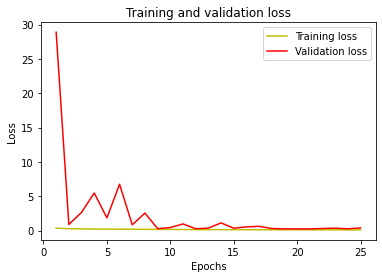

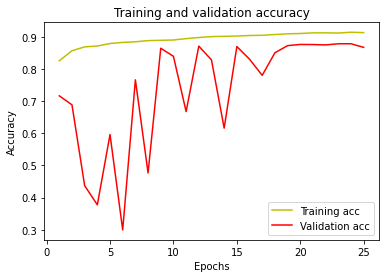

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/skin_lesion_25epochs.hdf5", compile=False)

In [ ]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

7/7 [==============================] - 3s 402ms/step


In [ ]:
from tensorflow.keras.metrics import MeanIoU

In [ ]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8065605


(1, 192, 256, 1)
1/1 [==============================] - 0s 20ms/step
(192, 256)


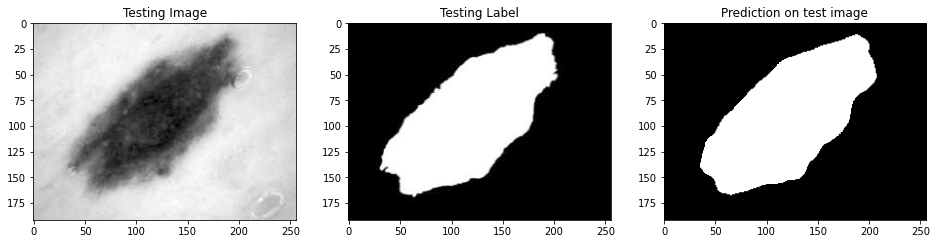

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()